<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/random_forest_res_shap_lime_8869.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install lime
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=dfc4d146a06e4702748df668177573ac726119be00bbb295576fd07f633c3712
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Load the dataset
file_path = 'model1_210_features.csv'
data = pd.read_csv(file_path)


=== Correlation of each feature with 'dropout' (descending) ===
dropout              1.000000
day_30_wiki         -0.015062
day_20_wiki         -0.019370
day_28_wiki         -0.022138
day_29_wiki         -0.024976
day_27_wiki         -0.025108
day_11_wiki         -0.030351
day_17_wiki         -0.031673
day_21_wiki         -0.032608
day_22_wiki         -0.034441
day_25_wiki         -0.036512
day_24_wiki         -0.036938
day_26_wiki         -0.037370
day_5_wiki          -0.038532
day_10_wiki         -0.040052
day_23_wiki         -0.042845
day_30_discussion   -0.042918
day_13_wiki         -0.043419
day_12_wiki         -0.043437
day_9_wiki          -0.044936
day_19_wiki         -0.047172
day_6_wiki          -0.050100
day_14_wiki         -0.051187
day_16_wiki         -0.052112
day_18_wiki         -0.052178
day_8_wiki          -0.053144
day_4_wiki          -0.054380
day_20_discussion   -0.056613
day_27_discussion   -0.056864
day_2_wiki          -0.057057
day_3_wiki          -0.057069
day_7

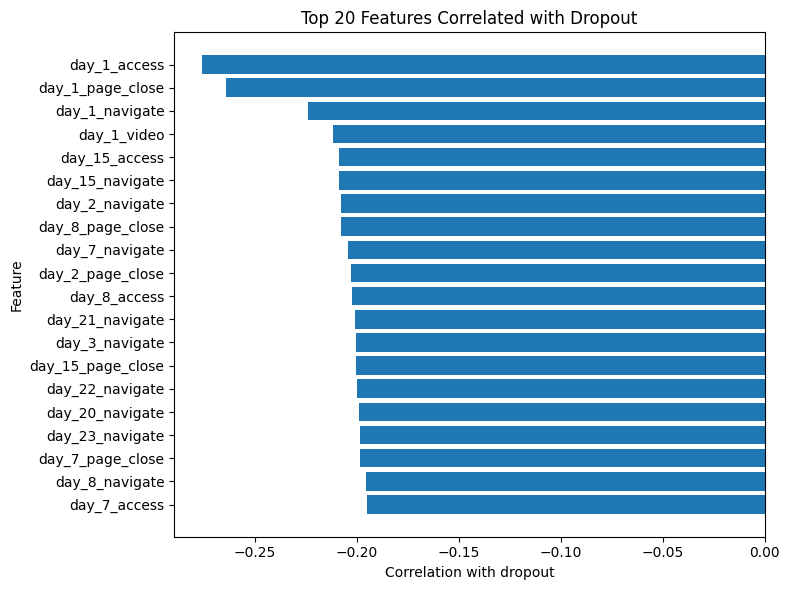

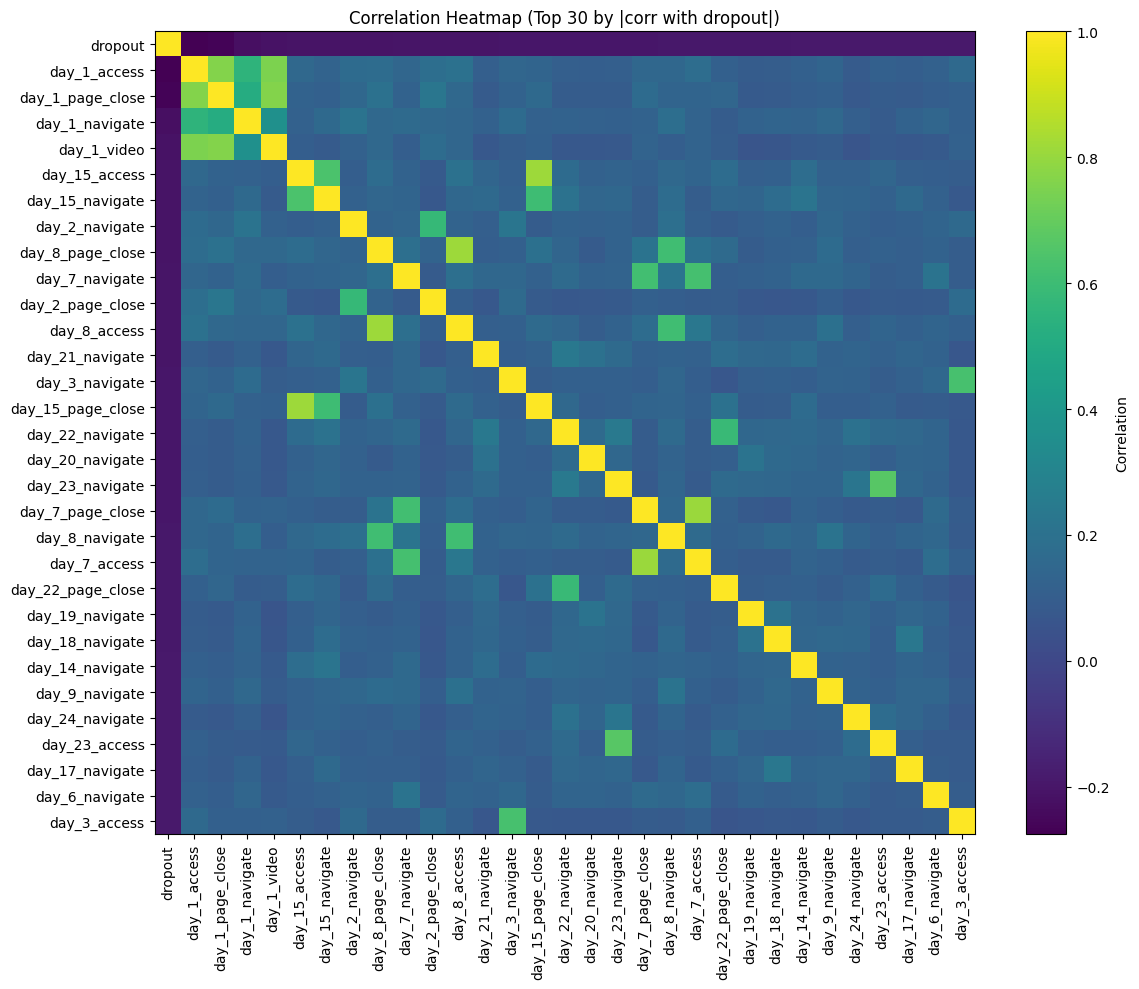

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best RandomForest Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

=== Test Metrics ===
Accuracy : 0.8869
Precision: 0.8647
Recall   : 0.9173
F1 Score : 0.8902
--------------------------------------------------


In [ ]:
# -*- coding: utf-8 -*-
"""
Random Forest + SHAP + LIME pipeline with correlation analysis.
- Loads dataset `model1_210_features.csv`
- Cleans and preprocesses
- Adds correlation matrix and top-correlated features with `dropout`
- Trains a RandomForest with RandomizedSearchCV + SMOTE
- Prints metrics and prepares SHAP values

Notes:
- Remove or adjust file_path if you run from a different working directory.
- The correlation heatmap is limited to the top 30 features most correlated with `dropout`
  (to keep the visualization readable with 200+ columns).
"""

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# -----------------------------
# Configuration
# -----------------------------
file_path = 'model1_210_features.csv'  # Adjust if needed
random_state = 42
test_size = 0.2

def safe_drop(df: pd.DataFrame, cols):
    """Drop columns if they exist; ignore if not present."""
    return df.drop(columns=[c for c in cols if c in df.columns], errors='ignore')

def plot_correlation_heatmap(corr_df: pd.DataFrame, title: str):
    """Plot a correlation heatmap using matplotlib only (no seaborn)."""
    plt.figure(figsize=(12, 10))
    plt.imshow(corr_df, interpolation='none', aspect='auto')
    plt.colorbar(label='Correlation')
    ticks = np.arange(len(corr_df.columns))
    plt.xticks(ticks, corr_df.columns, rotation=90)
    plt.yticks(ticks, corr_df.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_top_corr_bar(corr_series: pd.Series, top_n: int = 20):
    """Bar chart for top-N correlations with dropout (absolute value sorting)."""
    top_features = corr_series.drop(labels=['dropout'], errors='ignore')
    # Sort by absolute correlation, keep sign for the bar direction
    top_features = top_features.reindex(top_features.abs().sort_values(ascending=False).head(top_n).index)
    plt.figure(figsize=(8, 6))
    plt.barh(top_features.index, top_features.values)
    plt.xlabel('Correlation with dropout')
    plt.ylabel('Feature')
    plt.title(f'Top {min(top_n, len(top_features))} Features Correlated with Dropout')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def main():
    # -----------------------------
    # Load data
    # -----------------------------
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Could not find '{file_path}'. Put the CSV next to this script or update file_path.")

    data = pd.read_csv(file_path)

    # Drop non-feature text IDs if present
    data = safe_drop(data, ['username', 'course_id', 'enrollment_id'])

    # Basic NA handling (adjust as needed)
    data = data.fillna(0)

    # Ensure `dropout` exists
    if 'dropout' not in data.columns:
        raise KeyError("Column 'dropout' not found in the dataset. Please ensure it exists in the CSV.")

    # -----------------------------
    # Correlation analysis (BEFORE scaling/SMOTE)
    # -----------------------------
    numeric_df = data.select_dtypes(include=[np.number])
    corr_full = numeric_df.corr()

    if 'dropout' in corr_full.columns:
        corr_with_dropout = corr_full['dropout'].sort_values(ascending=False)
        print("\n=== Correlation of each feature with 'dropout' (descending) ===")
        print(corr_with_dropout.to_string())

        # Plot bar of top correlated with dropout (excluding the target itself)
        plot_top_corr_bar(corr_with_dropout, top_n=20)

        # Heatmap on top-30 absolute correlations (including 'dropout')
        top_cols = corr_with_dropout.abs().sort_values(ascending=False).head(31).index.tolist()
        sub_corr = corr_full.loc[top_cols, top_cols]
        plot_correlation_heatmap(sub_corr, title="Correlation Heatmap (Top 30 by |corr with dropout|)")
    else:
        print("Warning: 'dropout' not in correlation matrix (check that it's numeric 0/1). Skipping correlation plots.")

    # -----------------------------
    # Train/test split and modeling
    # -----------------------------
    X = data.drop(columns=['dropout'])
    y = data['dropout']

    # Scale features (mainly helpful for non-tree models; harmless for trees)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance with SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=test_size, random_state=random_state, stratify=y_resampled
    )

    # RandomizedSearchCV for Random Forest
    param_dist_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist_rf,
        n_iter=100,
        cv=3,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rf_random_search.fit(X_train, y_train)

    best_rf = rf_random_search.best_estimator_
    print("\nBest RandomForest Params:", rf_random_search.best_params_)

    y_pred = best_rf.predict(X_test)

    print("\n=== Test Metrics ===")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print("-" * 50)

    # -----------------------------
    # Explainability with SHAP (tree-based)
    # -----------------------------
    try:
        explainer_rf = shap.TreeExplainer(best_rf)
        shap_values_rf = explainer_rf.shap_values(X_test)
        # You can uncomment the following lines to show plots when running interactively:
        # shap.summary_plot(shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf,
        #                   X_test, feature_names=X.columns)
        print("SHAP values computed for RandomForest.")
    except Exception as e:
        print(f"SHAP computation skipped due to: {e}")

if __name__ == '__main__':
    main()


In [ ]:
# Drop non-numeric columns that are not useful for prediction
data = data.drop(columns=['username', 'course_id', 'enrollment_id'])

In [ ]:
data

,day_1_access,day_1_problem,day_1_wiki,day_1_discussion,day_1_navigate,day_1_page_close,day_1_video,day_2_access,day_2_problem,day_2_wiki,...,day_29_page_close,day_29_video,day_30_access,day_30_problem,day_30_wiki,day_30_discussion,day_30_navigate,day_30_page_close,day_30_video,dropout
0,3,8,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,14,0,0,4,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18,5,0,0,4,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,0,28,16,0,...,2,3,14,6,0,0,1,4,8,0
4,12,2,0,0,5,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120537,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
120538,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
120539,3,0,0,0,2,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
120540,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Handle missing values (fill with 0 or use mean/median imputation as necessary)
data.fillna(0, inplace=True)

In [ ]:
# Separate features and target variable
X = data.drop(columns=['dropout'])  # Features
y = data['dropout']  # Target variable

In [ ]:
# Standardize the features (important for models like Logistic Regression and XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[-0.40707638,  0.53033215, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884],
       [-0.10503681,  1.14410491, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884],
       [ 0.72557199,  0.22344576, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884],
       ...,
       [-0.40707638, -0.28803154, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884],
       [-0.63360605, -0.28803154, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884],
       [-0.63360605, -0.28803154, -0.23498888, ..., -0.06765905,
        -0.05627818, -0.05027884]])

In [ ]:
# Handle class imbalance using SMOTE (oversampling the minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# RandomizedSearchCV for hyperparameter tuning (for Random Forest)
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=100, cv=3, random_state=42)
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42)

In [ ]:

# Best models from RandomizedSearchCV
best_rf = rf_random_search.best_estimator_

In [ ]:
y_pred = best_rf.predict(X_test)

In [ ]:
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("-" * 50)

Accuracy: 0.8848
Precision: 0.8644
Recall: 0.9129
F1 Score: 0.8880
--------------------------------------------------
